In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm, zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

import time

# to ignore warnings
import warnings

warnings.filterwarnings("ignore")

Load the two Datasets

In [2]:
pick_data_original = pd.read_csv(
    "003_pick_data.csv",
    names=[
        "SKU", "Warehouse_Section",
        "Origin", "Order_No",
        "Position_in_Order", "Pick_Volume",
        "Unit", "Date",
    ],
    header=None,
    encoding="latin1",
    low_memory=False,
)
print(pick_data_original.shape)
pick_data_original.info()

(33888990, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888990 entries, 0 to 33888989
Data columns (total 8 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   SKU                object
 1   Warehouse_Section  object
 2   Origin             int64 
 3   Order_No           object
 4   Position_in_Order  int64 
 5   Pick_Volume        int64 
 6   Unit               object
 7   Date               object
dtypes: int64(3), object(5)
memory usage: 2.0+ GB


In [3]:
product_data_original = pd.read_csv(
    "002_product_data.csv",
    names=["SKU", "Description", "Product_Group"],
    header=None,
    encoding="latin1",
    engine="python",
    error_bad_lines=False,
    quoting=3,
)
print(product_data_original.shape)
product_data_original.info()

(2199644, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199644 entries, 0 to 2199643
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   SKU            object
 1   Description    object
 2   Product_Group  object
dtypes: object(3)
memory usage: 50.3+ MB


Handling Mixed Datatypes

In [5]:
# Converting the variables to the appropriate datatypes helps with better memory efficiency
pick_data_original[["Warehouse_Section", "Unit"]] = pick_data_original[["Warehouse_Section", "Unit"]].astype("category")
pick_data_original[["SKU", "Order_No"]] = pick_data_original[["SKU", "Order_No"]].astype("string")
pick_data_original["Date"] = pd.to_datetime(pick_data_original["Date"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
pick_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33888990 entries, 0 to 33888989
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   SKU                string        
 1   Warehouse_Section  category      
 2   Origin             int64         
 3   Order_No           string        
 4   Position_in_Order  int64         
 5   Pick_Volume        int64         
 6   Unit               category      
 7   Date               datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(3), string(2)
memory usage: 1.6 GB


In [6]:
product_data_original[["SKU", "Description", "Product_Group"]] = product_data_original[
    ["SKU", "Description", "Product_Group"]].astype("string")
product_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199644 entries, 0 to 2199643
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   SKU            string
 1   Description    string
 2   Product_Group  string
dtypes: string(3)
memory usage: 50.3 MB


Display the first 5 records of each dataset

In [7]:
pick_data_original.head()

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date
0,000002,SHL,48,07055448,1,29,St,2017-06-30 11:15:24
1,000002,SHL,48,07055448,1,30,St,2017-06-30 11:22:35
2,000002,SHL,48,07055448,1,30,St,2017-06-30 12:04:50
3,000002,SHL,48,07055448,1,20,St,2017-06-30 12:04:51
4,000002,SHL,48,07055448,1,30,St,2017-06-30 12:05:02


In [8]:
product_data_original.head()

,SKU,Description,Product_Group
0,000052,"""PUNCH II MSW1 1500mm PUN""",35_Leuchten
1,1036628,"""H05VV-F2X1 5WS 50M""",16_Sonderverkäufe
2,1052053,"""H07RN-F3G1 100M""",16_Sonderverkäufe
3,110109,"""SIEM DELTA Doppelta 2S 5TD2111""",32_Schalter_Steckvorrichtg
4,110125,"""SIEM PLUS Wip Univ ews 5TG7581""",32_Schalter_Steckvorrichtg


Analyzing and Cleaning Product Data dataset

In [9]:
product_data_transformed = product_data_original.copy(deep=True)
product_data_transformed["Description"] = product_data_transformed["Description"].replace('""', np.nan)
product_data_transformed.isnull().sum()

SKU                 0
Description      6023
Product_Group       0
dtype: int64

Replace the null Descriptions with the value "No Description"

In [10]:
# Strip any leading or trailing double quotes from Description
product_data_transformed["Description"] = product_data_transformed["Description"].str.strip('"')
product_data_transformed["Description"] = product_data_transformed["Description"].fillna("No Description")
print(product_data_transformed.nunique())
print(product_data_transformed.info())

SKU              2199644
Description      1422863
Product_Group         18
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199644 entries, 0 to 2199643
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   SKU            string
 1   Description    string
 2   Product_Group  string
dtypes: string(3)
memory usage: 50.3 MB
None


### Dealing with Umlauts

In [13]:
# Step 1: Define a mapping for the German umlauts to their respective replacements
umlaut_mapping = {
    "ä": "ae", "ö": "oe",
    "ü": "ue", "ß": "ss",
    "Ä": "Ae", "Ö": "Oe",
    "Ü": "Ue",
}

# Step 2: Define a function to replace umlauts using the mapping
def replace_umlauts(text):
    """
    Replaces German umlauts and the 'ß' character in the input string with their respective replacements.
    
    The function uses a predefined mapping for common German umlauts:
        - ä -> ae
        - ö -> oe
        - ü -> ue
        - ß -> ss
        - Ä -> Ae
        - Ö -> Oe
        - Ü -> Ue
    
    Args:
        text (str): A string in which umlauts and 'ß' will be replaced.
    
    Returns:
        str: A string with all occurrences of umlauts replaced by their corresponding values.
              If the input is not a string, the original value is returned unchanged.
    """
    if isinstance(text, str):  # Ensure that the input is a string
        for umlaut, replacement in umlaut_mapping.items():
            text = text.replace(umlaut, replacement)
    return text

product_data_transformed[["Description", "Product_Group"]] = product_data_transformed[
    ["Description", "Product_Group"]].applymap(replace_umlauts)

product_data_transformed.head()

,SKU,Description,Product_Group
0,000052,PUNCH II MSW1 1500mm PUN,35_Leuchten
1,1036628,H05VV-F2X1 5WS 50M,16_Sonderverkaeufe
2,1052053,H07RN-F3G1 100M,16_Sonderverkaeufe
3,110109,SIEM DELTA Doppelta 2S 5TD2111,32_Schalter_Steckvorrichtg
4,110125,SIEM PLUS Wip Univ ews 5TG7581,32_Schalter_Steckvorrichtg


### Analyzing Pick Data dataset

In [14]:
pick_data_original.duplicated().sum()

8024

Removing the duplicates and storing in a new DataFrame called `pick_data_transformed` that'll contain all future transformations

In [15]:
pick_data_transformed = pick_data_original.drop_duplicates()
pick_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33880966 entries, 0 to 33888989
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   SKU                string        
 1   Warehouse_Section  category      
 2   Origin             int64         
 3   Order_No           string        
 4   Position_in_Order  int64         
 5   Pick_Volume        int64         
 6   Unit               category      
 7   Date               datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(3), string(2)
memory usage: 1.8 GB


In [16]:
pick_data_transformed.nunique()

SKU                     97317
Warehouse_Section           5
Origin                      2
Order_No              6928668
Position_in_Order         340
Pick_Volume              1690
Unit                        9
Date                 22874561
dtype: int64

### Repeating Order Numbers

Objective: We observed that certain Order Numbers reappear multiple times in the dataset across multiple years. Hence, we need to correct the occurences of such Orders. For example, the `Order_No` "01000022" has appeared across the years 2015, 2019 and 2020

In [17]:
pick_data_transformed[pick_data_transformed["Order_No"] == "01000022"]

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date
2206404,202873,Manuell,48,01000022,1,100,Mt,2020-05-14 18:13:16
3677888,230333,SHL,48,01000022,2,4,Ro,2020-05-14 20:51:07
3681575,230344,AKL,48,01000022,3,400,St,2020-05-14 20:53:56
14993127,V65319,SHL,48,01000022,2,10,St,2019-05-22 13:59:51
27402014,168184,Kabellager,48,01000022,1,50,Mt,2015-04-16 19:22:01


In [18]:
pick_data_transformed[pick_data_transformed["Order_No"] == "09928757"]

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date
27364068,P55156,AKL,48,09928757,1,10,St,2015-04-13 17:48:22
27417948,222950,Manuell,48,09928757,2,4,Mt,2015-04-20 03:53:54
27417949,221254,Manuell,48,09928757,3,44,Mt,2015-04-20 03:53:54


Approach:

Need to transform the Order Numbers and make them unique by adding special characters at the end in the format Order No + _v + version. Will be stored in a new variable called `Unique_Order_No`
Ex: 01000022_v1

Will split an `Order_No` into `Unique_Order_No` when the `Origin` changes across picks. Do not split orders based on time gaps if other attributes like `Position_in_Order`, `SKU` indicate a continuous order process. Will preserve the original `Position_in_Order` to maintain its logical sequence within a `Unique_Order_No`.

In [22]:
def generate_unique_order_no(df, time_gap_threshold, large_gap_threshold_months=2):
    """
    This fn is to generate unique order no.s and the params are ...
    """
    # Step 1: Sort the dataframe by Order_No and Date
    df = df.sort_values(by=["Order_No", "Date"]).reset_index(drop=True)
    # Step 2: Precompute thresholds
    large_gap_threshold_seconds = (
        large_gap_threshold_months * 30.44 * 24 * 60 * 60
    )  # Convert months to seconds
    # Step 3: Calculate time differences using shift()
    df["Time_Difference"] = (df["Date"] - df["Date"].shift()).dt.total_seconds()
    # Reset Time_Difference to NaN where Order_No changes
    df["Time_Difference"] = df["Time_Difference"].where(
        df["Order_No"] == df["Order_No"].shift(), other=None
    )
    # Step 4: Initialize an empty list to store the Unique_Order_No for each row
    unique_order_no_list = pd.Series([None] * len(df), index=df.index)
    # Step 5: Group by Order_No for processing
    for order_no, group in df.groupby("Order_No", sort=False):
        # Initialize tracking variables
        unique_order_id = 1
        last_seen_rows = set()
        seen_positions = set()
        seen_skus = set()
        previous_origin = None

        for idx, (row_idx, row) in enumerate(group.iterrows()):
            if idx == 0:
                # First row always starts a new Unique_Order_No
                unique_order_no_list[row_idx] = f"{order_no}_v{unique_order_id}"
                last_seen_rows.add((row["Position_in_Order"], row["SKU"]))
                seen_positions.add(row["Position_in_Order"])
                seen_skus.add(row["SKU"])
                previous_origin = row["Origin"]
            else:
                # Fetch precomputed time gap
                time_gap = row["Time_Difference"]
                origin_changed = row["Origin"] != previous_origin
                large_gap = (
                    time_gap > large_gap_threshold_seconds
                    if not pd.isna(time_gap)
                    else False
                )
                long_gap = (
                    time_gap >= time_gap_threshold if not pd.isna(time_gap) else False
                )

                # Check SKU/Position logic
                pair_in_last_seen = (
                    row["Position_in_Order"],
                    row["SKU"],
                ) in last_seen_rows
                position_or_sku_in_last_seen = (
                    row["Position_in_Order"] in seen_positions
                    or row["SKU"] in seen_skus
                )

                # Logic to trigger a split
                if (
                    origin_changed
                    or large_gap
                    or (
                        long_gap
                        and not pair_in_last_seen
                        and position_or_sku_in_last_seen
                    )
                ):
                    unique_order_id += 1
                    last_seen_rows = set()
                    seen_positions = set()
                    seen_skus = set()

                # Update Unique_Order_No and tracking variables
                unique_order_no_list[row_idx] = f"{order_no}_v{unique_order_id}"
                last_seen_rows.add((row["Position_in_Order"], row["SKU"]))
                seen_positions.add(row["Position_in_Order"])
                seen_skus.add(row["SKU"])
                previous_origin = row["Origin"]

    # Step 6: Assign the generated Unique_Order_No values to the DataFrame
    df["Unique_Order_No"] = unique_order_no_list

    return df

In [23]:
pick_data_transformed = generate_unique_order_no(pick_data_transformed, 432000, 2)
pick_data_transformed.head()

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date,Time_Difference,Unique_Order_No
0,F80856,SHL,48,01000000,8,1,St,2020-05-14 15:55:18,NaN,01000000_v1
1,Z71504,SHL,48,01000000,9,1,St,2020-05-14 15:55:18,0.0,01000000_v1
2,C06077,SHL,48,01000000,1,1,St,2020-05-14 15:55:19,1.0,01000000_v1
3,E20007,SHL,48,01000000,3,1,St,2020-05-14 15:55:19,0.0,01000000_v1
4,E20008,SHL,48,01000000,2,1,St,2020-05-14 15:55:19,0.0,01000000_v1


In [24]:
pick_data_transformed[["Unique_Order_No"]] = pick_data_transformed[["Unique_Order_No"]].astype("string")
print(pick_data_transformed.nunique())

SKU                     97317
Warehouse_Section           5
Origin                      2
Order_No              6928668
Position_in_Order         340
Pick_Volume              1690
Unit                        9
Date                 22874561
Time_Difference       2287883
Unique_Order_No       9371179
dtype: int64


What we can see is that the number of distinct Order numbers has significantly increased from around 7 million to 9.4 million

In [25]:
pick_data_transformed[pick_data_transformed['Order_No'] == '01007725']

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date,Time_Difference,Unique_Order_No
42187,302001,AKL,46,01007725,8,1,St,2015-04-20 06:04:08,NaN,01007725_v1
42188,302001,AKL,46,01007725,8,1,St,2015-04-20 06:16:28,740.0,01007725_v1
42189,O68047,HRL,46,01007725,7,0,St,2015-04-20 07:27:38,4270.0,01007725_v1
42190,101621,HRL,46,01007725,6,200,Mt,2015-04-20 07:32:59,321.0,01007725_v1
42191,453035,HRL,46,01007725,2,2,St,2015-04-20 07:33:34,35.0,01007725_v1
42192,302001,HRL,46,01007725,8,3,St,2015-04-20 07:34:28,54.0,01007725_v1
42193,G04600,HRL,46,01007725,3,10,St,2015-04-20 07:37:03,155.0,01007725_v1
42194,392655,HRL,46,01007725,1,2,St,2015-04-20 07:42:52,349.0,01007725_v1
42195,161102,HRL,46,01007725,5,1000,Mt,2015-04-20 08:01:58,1146.0,01007725_v1
42196,O68047,HRL,46,01007725,7,1,St,2015-04-27 06:09:19,598041.0,01007725_v1


From this example, we can see that `Position_in_Order` 4 is missing and there are a few orders like this that needs to be fixed

So we need to reorder `Position_in_Order` correctly

In [26]:
# Sort by Unique_Order_No and Position_in_Order
pick_data_transformed = pick_data_transformed.sort_values(
    by=["Unique_Order_No", "Position_in_Order"]
)

# Renumber Position_in_Order efficiently
pick_data_transformed["Position_in_Order_Updated_Rank"] = (
    pick_data_transformed.groupby("Unique_Order_No")["Position_in_Order"]
    .rank(method="dense")
    .astype(int)
)

pick_data_transformed = pick_data_transformed.sort_values(
    by=["Unique_Order_No", "Date"]
).reset_index(drop=True)

In [28]:
pick_data_transformed[pick_data_transformed['Order_No'] == '01007725']

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date,Time_Difference,Unique_Order_No,Position_in_Order_Updated_Rank
42187,302001,AKL,46,01007725,8,1,St,2015-04-20 06:04:08,NaN,01007725_v1,7
42188,302001,AKL,46,01007725,8,1,St,2015-04-20 06:16:28,740.0,01007725_v1,7
42189,O68047,HRL,46,01007725,7,0,St,2015-04-20 07:27:38,4270.0,01007725_v1,6
42190,101621,HRL,46,01007725,6,200,Mt,2015-04-20 07:32:59,321.0,01007725_v1,5
42191,453035,HRL,46,01007725,2,2,St,2015-04-20 07:33:34,35.0,01007725_v1,2
42192,302001,HRL,46,01007725,8,3,St,2015-04-20 07:34:28,54.0,01007725_v1,7
42193,G04600,HRL,46,01007725,3,10,St,2015-04-20 07:37:03,155.0,01007725_v1,3
42194,392655,HRL,46,01007725,1,2,St,2015-04-20 07:42:52,349.0,01007725_v1,1
42195,161102,HRL,46,01007725,5,1000,Mt,2015-04-20 08:01:58,1146.0,01007725_v1,4
42196,O68047,HRL,46,01007725,7,1,St,2015-04-27 06:09:19,598041.0,01007725_v1,6


### Analyzing 0 Pick_Volume

In [ ]:
# Step 1: Create a flag for rows with Pick_Vol = 0 and Pick_Vol > 0
pick_data_transformed["Pick_Vol_Zero_Flag"] = pick_data_transformed["Pick_Volume"] == 0
pick_data_transformed["Pick_Vol_Positive_Flag"] = pick_data_transformed["Pick_Volume"] > 0

# Step 2: Group by Unique_Order_No, SKU, and Position_in_Order
grouped = pick_data_transformed.groupby(["Unique_Order_No", "SKU", "Position_in_Order"])

# Step 3: Check conditions within each group
matching_orders = grouped.agg(
    {
        "Pick_Vol_Zero_Flag": "any",  # Check if Pick_Vol = 0 exists
        "Pick_Vol_Positive_Flag": "any",  # Check if Pick_Vol > 0 exists
    }
).reset_index()

# Step 4: Filter groups that meet the criteria
matching_orders["Has_Zero_and_Positive_Pick_Vol"] = (
    matching_orders["Pick_Vol_Zero_Flag"] & matching_orders["Pick_Vol_Positive_Flag"]
)
matching_orders["Has_Zero_but_No_Positive_Pick_Vol"] = (
    matching_orders["Pick_Vol_Zero_Flag"] & ~matching_orders["Pick_Vol_Positive_Flag"]
)

# Step 5: Get the count of Unique_Order_No that meet the criteria and the 
# count of the ones that don't
orders_with_zero_and_positive = matching_orders[
    matching_orders["Has_Zero_and_Positive_Pick_Vol"]
][
    "Unique_Order_No"
].unique()  # 145,829
problematic_orders = matching_orders[
    matching_orders["Has_Zero_but_No_Positive_Pick_Vol"]
][
    "Unique_Order_No"
].unique()  # 2215
overlap_orders = set(orders_with_zero_and_positive).intersection(
    problematic_orders
)  # 76 Unique Orders come under both categories

# Analyze the strictly problematic orders
strictly_problematic_orders = list(set(problematic_orders) - overlap_orders)

# Filter all rows for strictly problematic orders
strictly_problematic_orders_df = pick_data_transformed[
    pick_data_transformed["Unique_Order_No"].isin(strictly_problematic_orders)
]

### Analyzing Negative Pick_Volume

In [31]:
pick_data_transformed[pick_data_transformed["Pick_Volume"] < 0].head()

,SKU,Warehouse_Section,Origin,Order_No,Position_in_Order,Pick_Volume,Unit,Date,Time_Difference,Unique_Order_No,Position_in_Order_Updated_Rank
2597503,R12006,SHL,48,01670127,4,-3,St,2015-09-04 11:32:14,0.0,01670127_v1,2
2605596,294723,SHL,48,01672819,6,-1,St,2015-09-04 13:06:53,0.0,01672819_v1,4
2811329,234142,SHL,48,01723719,9,-25,St,2015-09-15 16:32:15,0.0,01723719_v1,7
2829393,206454,SHL,48,01728544,1,-10,St,2015-09-16 14:35:49,0.0,01728544_v1,1
2863654,R20556,SHL,48,01737252,6,-1,St,2015-09-17 13:14:25,0.0,01737252_v1,6


In [29]:
pick_data_transformed[pick_data_transformed["Pick_Volume"] < 0].nunique()

SKU                               99
Warehouse_Section                  1
Origin                             2
Order_No                          94
Position_in_Order                 11
Pick_Volume                       21
Unit                               2
Date                              95
Time_Difference                    4
Unique_Order_No                   94
Position_in_Order_Updated_Rank    11
dtype: int64

We've 94 distinct orders that contain negative pick volume and these were recorded only from SHL warehouse section

In [30]:
pick_data_transformed[pick_data_transformed["Pick_Volume"] < 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 2597503 to 33876739
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   SKU                             100 non-null    string        
 1   Warehouse_Section               100 non-null    category      
 2   Origin                          100 non-null    int64         
 3   Order_No                        100 non-null    string        
 4   Position_in_Order               100 non-null    int64         
 5   Pick_Volume                     100 non-null    int64         
 6   Unit                            100 non-null    category      
 7   Date                            100 non-null    datetime64[ns]
 8   Time_Difference                 100 non-null    float64       
 9   Unique_Order_No                 100 non-null    string        
 10  Position_in_Order_Updated_Rank  100 non-null    int32         


Cleaning Negative Pick Volume

In [32]:
PICK_VOLUME = "Pick_Volume"
# Storing all indices that have -ve Pick Vol in a list
negative_indices = pick_data_transformed.index[
    pick_data_transformed[PICK_VOLUME] < 0
].to_list()  
print(len(negative_indices))

100


"Condition": Decided to merge the rows containing negative pick volume with the row that had an exact match of all the other parameters. And in or case the row right above is what we'll be making the comparison with

In [33]:
# All the indices which didn't match the "Condition" are stored in this list
missed_indices = []
# All the indices which matched the "Condition" but the sum of Pick_Volume equalled 0
missed_indices_sum_0 = []
# List to collect indices that need to be dropped
indices_to_drop = []
unique_order_nos_condition_failed = []
unique_order_nos_pick_volume_sum_0 = []
unique_order_nos_dropped = []

columns_to_drop_before_compare = pick_data_transformed.columns.difference(
    [PICK_VOLUME, "Pick_Vol_Positive_Flag", "Pick_Vol_Zero_Flag", "Time_Difference"]
)

for index in negative_indices:
    if index > 0:  # Ensure there's a row above to compare with
        # Row above the one with negative pick volume
        row_above = pick_data_transformed.loc[
            index - 1, columns_to_drop_before_compare
        ]
        
        # Row with negative pick volume. Selecting only relevant columns for comparison
        negative_row = pick_data_transformed.loc[
            index, columns_to_drop_before_compare
        ]

        # Compare rows excluding 'pick_volume'
        if row_above.equals(negative_row):
            # Combine the 'Pick_Volume' values
            combined_pick_volume = (
                pick_data_transformed.at[index - 1, PICK_VOLUME]
                + pick_data_transformed.at[index, PICK_VOLUME]
            )

            if combined_pick_volume > 0:
                # Update the pick_volume for the row_above
                pick_data_transformed.at[index - 1, PICK_VOLUME] = combined_pick_volume
                
                # Add the index of the negative pick_volume row to the drop list
                indices_to_drop.append(index)
                
                # Store the Unique_Order_No for the row being dropped
                unique_order_nos_dropped.append(
                    pick_data_transformed.at[index, "Unique_Order_No"]
                )
            else:
                # Track where combined Pick_Volume is <= 0
                missed_indices_sum_0.append(index)
                
                # Store the Unique_Order_No for the row where combined Pick_Volume <= 0
                unique_order_nos_pick_volume_sum_0.append(
                    pick_data_transformed.at[index, "Unique_Order_No"]
                )
        else:
            # Track rows where they don't match
            missed_indices.append(index)
            
            # Store the Unique_Order_No where the 'Condition' failed
            unique_order_nos_condition_failed.append(
                pick_data_transformed.at[index, "Unique_Order_No"]
            )

print(len(indices_to_drop))
print(len(missed_indices))
print(len(missed_indices_sum_0))

71
15
14


We've already merged the sum of Pick_Volume and the 71 indices will be dropped

In [34]:
pick_data_transformed = pick_data_transformed.drop(indices_to_drop)
# Reset index to create a clean, sequential index
pick_data_transformed = pick_data_transformed.reset_index(drop=True)  
pick_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33880895 entries, 0 to 33880894
Data columns (total 11 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   SKU                             string        
 1   Warehouse_Section               category      
 2   Origin                          int64         
 3   Order_No                        string        
 4   Position_in_Order               int64         
 5   Pick_Volume                     int64         
 6   Unit                            category      
 7   Date                            datetime64[ns]
 8   Time_Difference                 float64       
 9   Unique_Order_No                 string        
 10  Position_in_Order_Updated_Rank  int32         
dtypes: category(2), datetime64[ns](1), float64(1), int32(1), int64(3), string(3)
memory usage: 2.2 GB


### Creating a custom df `unique_order_details` that will be used for some of the visualizations in PowerBI

In [35]:
# Grouping by 'Unique_Order_No' and getting the first and last timestamp for each order
unique_order_details = (
    pick_data_transformed.groupby("Unique_Order_No")
    .agg(
        Start_Time=("Date", "first"),
        End_Time=("Date", "last"),
    )
    .reset_index()
)

In [ ]:
# Add a new column with Unique warehouse sections in 2 steps
# Step 1: Aggregate unique Warehouse_Sections for each Unique_Order_No
unique_warehouse_sections = pick_data_transformed.groupby("Unique_Order_No")["Warehouse_Section"].agg(
    lambda x: ", ".join(x.unique()))

# Step 2: Map the result to unique_order_details
unique_order_details["Unique_Warehouse_Sections"] = unique_order_details["Unique_Order_No"].map(unique_warehouse_sections)

In [ ]:
# Add a new column with pick count per order in 2 steps
# Step 1: Count the number of rows per Unique_Order_No in pick_data
order_row_counts = pick_data_transformed.groupby("Unique_Order_No").size()

# Step 2: Add the new column to unique_order_details
unique_order_details["Pick_Count"] = unique_order_details["Unique_Order_No"].map(order_row_counts)

In [ ]:
# Add a new column that counts the number of unique warehouses per order
# Count the number of unique warehouse sections in each order
unique_order_details["Unique_Warehouse_Count"] = (
    unique_order_details["Unique_Warehouse_Sections"]
    .str.split(", ")
    .str.len()
    .fillna(0)
    .astype(int)
)

In [ ]:
# Add a new column with Unique SKUs in 2 steps
# Step 1: Aggregate unique SKUs for each Unique_Order_No
unique_skus = pick_data_transformed.groupby("Unique_Order_No")["SKU"].agg(lambda x: ", ".join(x.unique()))

# Step 2: Add the new column to unique_order_details
unique_order_details["Unique_SKUs"] = unique_order_details["Unique_Order_No"].map(unique_skus)

In [ ]:
# Add a new column that counts the number of unique SKUs per order
# Count the number of unique SKUs in each order
unique_order_details["Unique_SKU_Count"] = (
    unique_order_details["Unique_SKUs"].str.split(", ").str.len().fillna(0).astype(int)
)

In [ ]:
# Calculate time difference in seconds
unique_order_details["Time_Difference_Seconds"] = (
    unique_order_details["End_Time"] - unique_order_details["Start_Time"]
).dt.total_seconds()

In [38]:
unique_order_details.head()

,Unique_Order_No,Start_Time,End_Time,Unique_Warehouse_Sections,Pick_Count,Unique_Warehouse_Count,Unique_SKUs,Unique_SKU_Count,Time_Difference_Seconds
0,01000000_v1,2020-05-14 15:55:18,2020-05-14 15:55:19,SHL,9,1,"F80856, Z71504, C06077, E20008, E20007, E20019...",9,1.0
1,01000001_v1,2020-05-14 23:01:11,2020-05-14 23:01:13,SHL,5,1,"206452, 234112, 234114, G41665, G41660",5,2.0
2,01000002_v1,2015-04-16 15:16:37,2015-04-16 15:16:37,AKL,1,1,A80704,1,0.0
3,01000002_v2,2019-05-22 22:07:30,2019-05-22 22:07:31,SHL,5,1,"243095, 242738, 113725, 387126, 384304",5,1.0
4,01000002_v3,2020-05-14 15:47:45,2020-05-14 15:47:45,SHL,1,1,283136,1,0.0


### Univariate Analysis of the number of distinct products in Orders

In [39]:
# Step 1: Extract max Position_in_Order_Updated (i.e. no of distinct SKUs) for each Unique_Order_No
order_max_positions = (
    pick_data_transformed.groupby(["Unique_Order_No", "Origin"])[
        "Position_in_Order_Updated_Rank"
    ]
    .max()
    .reset_index()
)
order_max_positions.rename(columns={"Position_in_Order_Updated_Rank": "Distinct_SKUs_per_Order"}, inplace=True)

In [40]:
# Step 2: Stratify by Origin
store_orders = order_max_positions[order_max_positions["Origin"] == 46]
customer_orders = order_max_positions[order_max_positions["Origin"] == 48]

In [41]:
# Step 3: Basic statistics for each group
def summary_stats(group, column):
    """
    Calculate summary statistics for a specified column in a given group.
    
    Args:
        group (pandas.DataFrame or pandas.Series): The group of data (typically a subset of a DataFrame)
            for which summary statistics will be calculated. It is expected to contain the specified column.
        column (str): The name of the column for which the statistics will be calculated.
    
    Returns:
        dict: A dictionary containing the following statistics for the specified column:
            - 'count': The number of non-null entries in the column.
            - 'mean': The mean of the column.
            - 'median': The median of the column.
            - 'mode': The mode of the column (first mode if multiple modes exist).
            - 'min': The minimum value in the column.
            - 'max': The maximum value in the column.
            - 'std': The standard deviation of the column.
            - 'skew': The skewness of the column.
            - 'kurtosis': The kurtosis of the column.
    """
    stats = {
        "count": len(group),
        "mean": np.mean(group[column]),
        "median": np.median(group[column]),
        "mode": group[column].mode()[0] if not group[column].mode().empty else np.nan,
        "min": group[column].min(),
        "max": group[column].max(),
        "std": np.std(group[column]),
        "skew": skew(group[column]),
        "kurtosis": kurtosis(group[column]),
    }
    return stats

In [42]:
store_stats = summary_stats(store_orders, "Distinct_SKUs_per_Order")
customer_stats = summary_stats(customer_orders, "Distinct_SKUs_per_Order")
print("Store Orders Statistics:")
print(store_stats)
print("\nCustomer Orders Statistics:")
print(customer_stats)

Store Orders Statistics:
{'count': 1019622, 'mean': 6.66224149733921, 'median': 4.0, 'mode': 1, 'min': 1, 'max': 85, 'std': 7.662045234749806, 'skew': 2.7574850695234496, 'kurtosis': 9.70779227462919}

Customer Orders Statistics:
{'count': 8351557, 'mean': 2.9888722545987534, 'median': 2.0, 'mode': 1, 'min': 1, 'max': 338, 'std': 3.7193866366835007, 'skew': 5.31518380607057, 'kurtosis': 86.02681412452898}


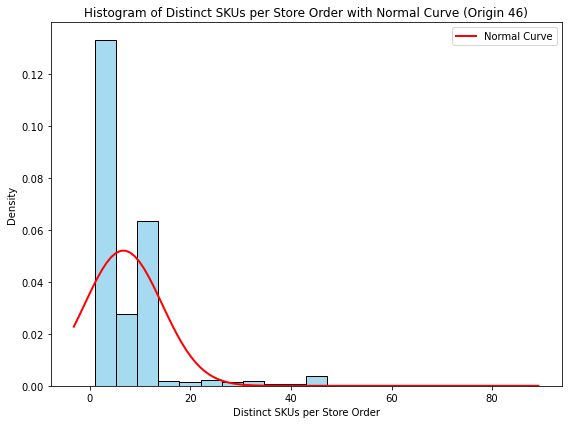

In [43]:
# Plot histogram and normal distribution curve for store_orders
plt.figure(figsize=(8, 6))

# Store Orders Histogram
sns.histplot(
    store_orders["Distinct_SKUs_per_Order"],
    kde=False,
    color="skyblue",
    bins=20,
    stat="density",
)
# Fit normal distribution and plot the curve
mu_store, std_store = norm.fit(store_orders["Distinct_SKUs_per_Order"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_store, std_store)
plt.plot(x, p, "r-", linewidth=2, label="Normal Curve")
plt.title("Histogram of Distinct SKUs per Store Order with Normal Curve (Origin 46)")
plt.xlabel("Distinct SKUs per Store Order")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

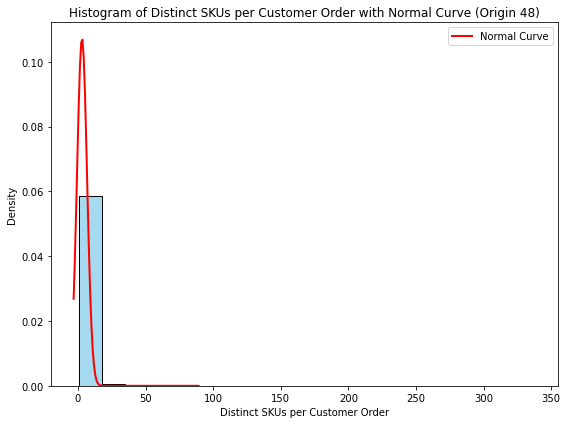

In [44]:
# Plot histogram and normal distribution curve for customer_orders
plt.figure(figsize=(8, 6))

# Customer Orders Histogram
sns.histplot(
    customer_orders["Distinct_SKUs_per_Order"],
    kde=False,
    color="skyblue",
    bins=20,
    stat="density",
)
# Fit normal distribution and plot the curve
mu_customer, std_customer = norm.fit(customer_orders["Distinct_SKUs_per_Order"])
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_customer, std_customer)
plt.plot(x, p, "r-", linewidth=2, label="Normal Curve")
plt.title("Histogram of Distinct SKUs per Customer Order with Normal Curve (Origin 48)")
plt.xlabel("Distinct SKUs per Customer Order")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
def detect_outliers_zscore(data, col_name, threshold=3):
    """
    Detect outliers in a specified column using the regular z-score method.
    
    Args:
        data (pandas.DataFrame): The dataframe containing the data to be processed.
        col_name (str): The name of the column for which outliers are to be detected.
        threshold (int, optional): The threshold for identifying outliers based on the z-score. 
                                      Defaults to 3. Values with an absolute z-score greater than this 
                                      threshold are flagged as outliers.

    Returns:
        pandas.DataFrame: The input dataframe with two additional columns:
            - 'Z_Score': The calculated z-scores for each entry in the specified column.
            - 'col_name_Outlier_Flag': A boolean flag indicating whether the corresponding entry is an outlier (True) 
              or not (False).
    """
    # Calculate z-scores for the specified column using scipy's zscore function
    data["Z_Score"] = zscore(data[col_name])

    # Flag outliers based on the threshold
    outlier_flag_col_name = col_name + "_Outlier_Flag"
    data[outlier_flag_col_name] = np.abs(data["Z_Score"]) > threshold

    return data

In [46]:
# Apply outlier detection for Store and Customer Orders
store_orders = detect_outliers_zscore(store_orders, "Distinct_SKUs_per_Order")
customer_orders = detect_outliers_zscore(customer_orders, "Distinct_SKUs_per_Order")

In [54]:
print(store_orders["Distinct_SKUs_per_Order_Outlier_Flag"].value_counts(normalize=True))
count_of_distinct_items_store = store_orders[~store_orders["Distinct_SKUs_per_Order_Outlier_Flag"]][
    "Distinct_SKUs_per_Order"].max()
print(f"The z-score test suggests that store orders, usually have upto {count_of_distinct_items_store} distinct items")

False    0.968895
True     0.031105
Name: Distinct_SKUs_per_Order_Outlier_Flag, dtype: float64
The z-score test suggests that store orders, usually have upto 29 distinct items


In [ ]:
print(customer_orders["Distinct_SKUs_per_Order_Outlier_Flag"].value_counts(normalize=True))
count_of_distinct_items_customer = customer_orders[~customer_orders["Distinct_SKUs_per_Order_Outlier_Flag"]][
    "Distinct_SKUs_per_Order"].max()
print(f"The z-score test suggests that customer orders, usually have upto {count_of_distinct_items_customer} distinct items")

False    0.980946
True     0.019054
Name: Distinct_SKUs_per_Order_Outlier_Flag, dtype: float64
The z-score test suggests that customer orders, usually have upto 14 distinct items


Conclusion:

There are only 3% of Store Orders and 2% of Customer Orders that are outliers based on the count of distinct products in them. We can also conclude that Stores purchase upto 29 distinct items per order whereas Customers purchase  upto 14 distinct items per order.

### Converting the transformed DataFrames into csv files to be stored into our MySQL Staging Database

In [ ]:
product_data_transformed.to_csv("product_data_transformed", index=False)
pick_data_transformed.to_csv("pick_data_transformed.csv", index=False)
unique_order_details.to_csv("unique_order_details", index=False)

### Prediction Modelling

The objective is to predict the number of picks that would occur on a given day for each Warehouse Section. By accurately forecasting the number of picks per day, OBETA could optimize manpower allocation and improve operational efficiency. This would ensure that sufficient resources are available for picking tasks while avoiding under or over-staffing.

In [3]:
pick_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33880895 entries, 0 to 33880894
Data columns (total 11 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   SKU                             object 
 1   Warehouse_Section               object 
 2   Origin                          int64  
 3   Order_No                        object 
 4   Position_in_Order               int64  
 5   Pick_Volume                     int64  
 6   Unit                            object 
 7   Date                            object 
 8   Time_Difference                 float64
 9   Unique_Order_No                 object 
 10  Position_in_Order_Updated_Rank  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ GB


In [4]:
pick_data_transformed[["Warehouse_Section", "Unit", "Origin"]] = pick_data_transformed[
    ["Warehouse_Section", "Unit", "Origin"]].astype("category")
pick_data_transformed["Date"] = pd.to_datetime(pick_data_transformed["Date"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
pick_data_transformed[["SKU", "Order_No", "Unique_Order_No"]] = pick_data_transformed[
    ["SKU", "Order_No", "Unique_Order_No"]].astype("string")
pick_data_transformed[["Position_in_Order", "Pick_Volume", "Position_in_Order_Updated_Rank"]] = pick_data_transformed[
    ["Position_in_Order", "Pick_Volume", "Position_in_Order_Updated_Rank"]].astype("int32")
pick_data_transformed.drop('Time_Difference', axis=1, inplace=True)

pick_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33880895 entries, 0 to 33880894
Data columns (total 10 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   SKU                             string        
 1   Warehouse_Section               category      
 2   Origin                          category      
 3   Order_No                        string        
 4   Position_in_Order               int32         
 5   Pick_Volume                     int32         
 6   Unit                            category      
 7   Date                            datetime64[ns]
 8   Unique_Order_No                 string        
 9   Position_in_Order_Updated_Rank  int32         
dtypes: category(3), datetime64[ns](1), int32(3), string(3)
memory usage: 1.5 GB


Create 'Date_only' as a new column (date without time)

In [5]:
pick_data_transformed['Date_only'] = pick_data_transformed['Date'].dt.date

Groupby Warehouse_Section and Date_only

In [6]:
# Calculate the target variable: the number of picks per day per section
picks_per_date = pick_data_transformed.groupby(['Warehouse_Section', 'Date_only']).size().reset_index(name='No_of_Picks')
print(picks_per_date.shape)
picks_per_date.head()

(14005, 3)


,Warehouse_Section,Date_only,No_of_Picks
0,AKL,2011-06-23,9478
1,AKL,2011-06-24,7959
2,AKL,2011-06-26,1115
3,AKL,2011-06-27,9811
4,AKL,2011-06-28,9120


Calculate the sum of Pick_Volume per Unit in each Warehouse_Section per day

In [7]:
pick_volume_daily_sum = pick_data_transformed.groupby(
    ['Warehouse_Section', 'Date_only', 'Unit'])['Pick_Volume'].sum().reset_index()
pick_volume_daily_sum.head()

,Warehouse_Section,Date_only,Unit,Pick_Volume
0,AKL,2011-06-23,Bl,1084
1,AKL,2011-06-23,Ei,0
2,AKL,2011-06-23,Mt,20315
3,AKL,2011-06-23,Pa,118
4,AKL,2011-06-23,Ro,69


Pivot to create separate columns for each Unit

In [8]:
pick_volume_daily_sum_pivot = pick_volume_daily_sum.pivot_table(
    index=['Warehouse_Section', 'Date_only'],
    columns='Unit',
    values='Pick_Volume',
    aggfunc='sum',
    fill_value=0
)
pick_volume_daily_sum_pivot.head(10)

Unit                            Bl  Ei     Mt   Pa  Ro  Se      St  VE  kg
Warehouse_Section Date_only                                               
AKL               2011-06-23  1084   0  20315  118  69  49  460640   0   0
                  2011-06-24   625   0   7430  105  37  21  403496   0   0
                  2011-06-26     7   0    850   10   6   4   23545   0   0
                  2011-06-27   691   0   8915  166  30  20  385515   0   0
                  2011-06-28   675   0   9080   96  59  57  408574   0   0
                  2011-06-29  1004   0  14545  111  38  19  415473   0   0
                  2011-06-30   751   0   6930  182  36  15  386337   0   0
                  2011-07-01   897   0   4580  207  86  29  326766   0   0
                  2011-07-03    78   0    110    8   0   5   19526   0   0
                  2011-07-04  1053   0  11705  160  25  42  329334   0   0

Merge the picks_per_date with the pick_volume_daily_sum_pivot

In [9]:
no_of_picks_and_pick_volume_per_date = pd.merge(
    picks_per_date, 
    pick_volume_daily_sum_pivot, 
    on=['Warehouse_Section', 'Date_only'], 
    how='left'
)
no_of_picks_and_pick_volume_per_date.head(10)

,Warehouse_Section,Date_only,No_of_Picks,Bl,Ei,Mt,Pa,Ro,Se,St,VE,kg
0,AKL,2011-06-23,9478,1084,0,20315,118,69,49,460640,0,0
1,AKL,2011-06-24,7959,625,0,7430,105,37,21,403496,0,0
2,AKL,2011-06-26,1115,7,0,850,10,6,4,23545,0,0
3,AKL,2011-06-27,9811,691,0,8915,166,30,20,385515,0,0
4,AKL,2011-06-28,9120,675,0,9080,96,59,57,408574,0,0
5,AKL,2011-06-29,9229,1004,0,14545,111,38,19,415473,0,0
6,AKL,2011-06-30,9224,751,0,6930,182,36,15,386337,0,0
7,AKL,2011-07-01,7239,897,0,4580,207,86,29,326766,0,0
8,AKL,2011-07-03,1174,78,0,110,8,0,5,19526,0,0
9,AKL,2011-07-04,9407,1053,0,11705,160,25,42,329334,0,0


In [10]:
no_of_picks_and_pick_volume_per_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14005 entries, 0 to 14004
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Warehouse_Section  14005 non-null  category
 1   Date_only          14005 non-null  object  
 2   No_of_Picks        14005 non-null  int64   
 3   Bl                 14005 non-null  int32   
 4   Ei                 14005 non-null  int32   
 5   Mt                 14005 non-null  int32   
 6   Pa                 14005 non-null  int32   
 7   Ro                 14005 non-null  int32   
 8   Se                 14005 non-null  int32   
 9   St                 14005 non-null  int32   
 10  VE                 14005 non-null  int32   
 11  kg                 14005 non-null  int32   
dtypes: category(1), int32(9), int64(1), object(1)
memory usage: 834.5+ KB


Handling datatypes

In [12]:
no_of_picks_and_pick_volume_per_date['Date_only'] = pd.to_datetime(
    no_of_picks_and_pick_volume_per_date['Date_only'], format="%Y-%m-%d", errors="coerce")
no_of_picks_and_pick_volume_per_date['No_of_Picks'] = no_of_picks_and_pick_volume_per_date['No_of_Picks'].astype('int')
no_of_picks_and_pick_volume_per_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14005 entries, 0 to 14004
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Warehouse_Section  14005 non-null  category      
 1   Date_only          14005 non-null  datetime64[ns]
 2   No_of_Picks        14005 non-null  int32         
 3   Bl                 14005 non-null  int32         
 4   Ei                 14005 non-null  int32         
 5   Mt                 14005 non-null  int32         
 6   Pa                 14005 non-null  int32         
 7   Ro                 14005 non-null  int32         
 8   Se                 14005 non-null  int32         
 9   St                 14005 non-null  int32         
 10  VE                 14005 non-null  int32         
 11  kg                 14005 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(10)
memory usage: 779.8 KB


SHL Warehouse_Section was introduced only from 2015-09-01 so filtering out the DataFrame

In [14]:
no_of_picks_and_pick_volume_per_date = no_of_picks_and_pick_volume_per_date[
    ~((no_of_picks_and_pick_volume_per_date['Warehouse_Section'] == 'SHL') & 
      (no_of_picks_and_pick_volume_per_date['Date_only'] < '2015-09-01'))
]
no_of_picks_and_pick_volume_per_date.shape

(12692, 12)

Feature Engineering

Time based features

In [ ]:
# Extract time-based features from 'Date'
no_of_picks_and_pick_volume_per_date['Day_of_Week'] = no_of_picks_and_pick_volume_per_date[
    'Date_only'].dt.dayofweek  # 0=Monday, 6=Sunday
no_of_picks_and_pick_volume_per_date['Is_Weekend'] = no_of_picks_and_pick_volume_per_date[
    'Day_of_Week'].isin([5, 6]).astype(int)  # 1 if weekend (Saturday or Sunday), else 0
no_of_picks_and_pick_volume_per_date['Month'] = no_of_picks_and_pick_volume_per_date['Date_only'].dt.month
no_of_picks_and_pick_volume_per_date['Year'] = no_of_picks_and_pick_volume_per_date['Date_only'].dt.year

# Applying sin and cos transformations to 'Day_of_Week' and Month (cyclic encoding)
no_of_picks_and_pick_volume_per_date['sin_day'] = np.sin(2 * np.pi * no_of_picks_and_pick_volume_per_date['Day_of_Week'] / 7)
no_of_picks_and_pick_volume_per_date['cos_day'] = np.cos(2 * np.pi * no_of_picks_and_pick_volume_per_date['Day_of_Week'] / 7)

no_of_picks_and_pick_volume_per_date['sin_month'] = np.sin(2 * np.pi * no_of_picks_and_pick_volume_per_date['Month'] / 12) 
no_of_picks_and_pick_volume_per_date['cos_month'] = np.cos(2 * np.pi * no_of_picks_and_pick_volume_per_date['Month'] / 12)

Adding Lag features. They're essentially a way to use past information (in this case no. of picks) to help with predictions. The Lag features are capturing how the number of picks on a given day depends on the number of picks in the past (such as 1 day ago, 7 days ago, 30 days ago, etc.)

In [21]:
# Sort the df and create a list of the Lag values (e.g. lag of 1 day, 7 days)
no_of_picks_and_pick_volume_per_date.sort_values(by=['Warehouse_Section', 'Date_only'], inplace=True)

lag_values = [1, 7, 30, 90, 180, 365]

for lag in lag_values:
    no_of_picks_and_pick_volume_per_date[f'Lag_{lag}_Days'] = no_of_picks_and_pick_volume_per_date.groupby(
        'Warehouse_Section')['No_of_Picks'].shift(lag)

no_of_picks_and_pick_volume_per_date['Warehouse_Section'] = no_of_picks_and_pick_volume_per_date[
    'Warehouse_Section'].astype('string')
no_of_picks_and_pick_volume_per_date.fillna(0, inplace=True)

In [22]:
no_of_picks_and_pick_volume_per_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12692 entries, 0 to 14004
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Warehouse_Section  12692 non-null  string        
 1   Date_only          12692 non-null  datetime64[ns]
 2   No_of_Picks        12692 non-null  int32         
 3   Bl                 12692 non-null  int32         
 4   Ei                 12692 non-null  int32         
 5   Mt                 12692 non-null  int32         
 6   Pa                 12692 non-null  int32         
 7   Ro                 12692 non-null  int32         
 8   Se                 12692 non-null  int32         
 9   St                 12692 non-null  int32         
 10  VE                 12692 non-null  int32         
 11  kg                 12692 non-null  int32         
 12  Day_of_Week        12692 non-null  int64         
 13  Is_Weekend         12692 non-null  int32         
 14  Month 

Correlation Analysis

In [23]:
numeric_features = no_of_picks_and_pick_volume_per_date.columns[2:]
numeric_features

Index(['No_of_Picks', 'Bl', 'Ei', 'Mt', 'Pa', 'Ro', 'Se', 'St', 'VE', 'kg',
       'Day_of_Week', 'Is_Weekend', 'Month', 'Year', 'sin_day', 'cos_day',
       'sin_month', 'cos_month', 'Lag_1_Days', 'Lag_7_Days', 'Lag_30_Days',
       'Lag_90_Days', 'Lag_180_Days', 'Lag_365_Days'],
      dtype='object')

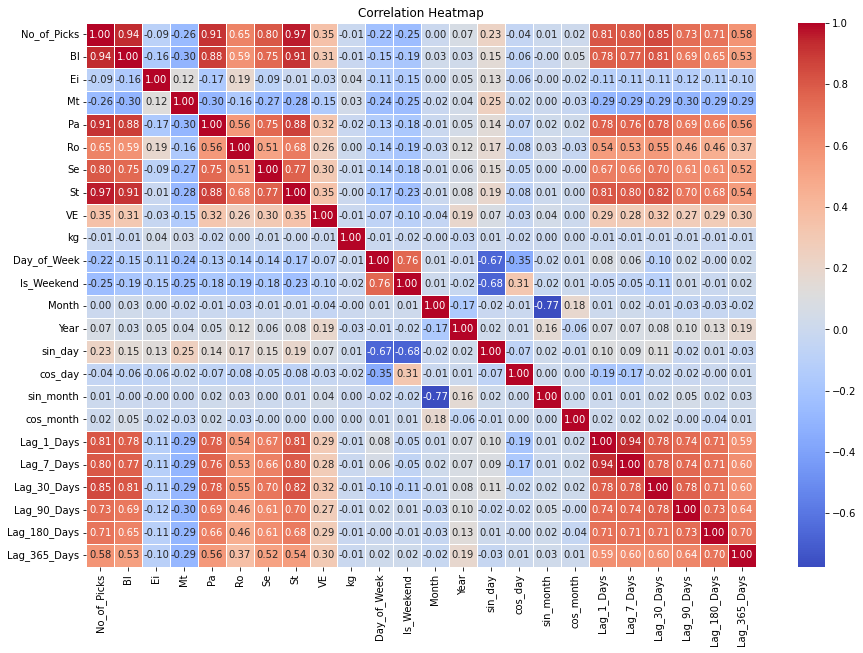

In [25]:
corr_matrix = no_of_picks_and_pick_volume_per_date[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Based on the heatmap, we can see that the sum of Pick Volume per unit (St, Bl, Pa) have high correlation values with our target variable `No_of_Picks`. Same can be said about the time based Lag features. But we shouldn't include all variables with a large correlation value in order to prevent Multicollinearity as this would negatively affect the predictions. Based on the values, we decided to go with `St`, `Mt`, `Ro`, `VE`, `Is_Weekend` and `Lag_30_Days` as our input features

### Data Preparation

Step 1: Preparing X and y

In [49]:
# The df was previously grouped by Warehouse_Section and sorted by date
# Need to re-sort by time to make it consistent else the train-test split 
# will miss some Warehouse_Section
no_of_picks_and_pick_volume_per_date.sort_values('Date_only', inplace=True)
X = no_of_picks_and_pick_volume_per_date[['St', 'Mt', 'Ro', 'VE', 'Is_Weekend', 'Lag_30_Days', 'Warehouse_Section']]
y = no_of_picks_and_pick_volume_per_date['No_of_Picks']

Step 2: Splitting the data into training and testing sets (80% training and 20% testing)

In [50]:
# The shuffle parameter in train_test_split is used to control whether the data is shuffled
# before splitting it into training and testing sets. When shuffle=False, the data is not shuffled, 
# and the split is performed in a sequential manner. This can be useful for time-series data where 
# the order of the data points is meaningful and should be preserved.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Step 3: Identify Numerical and Categorical Columns

In [51]:
numerical_columns = ['St', 'Mt', 'Ro', 'VE', 'Is_Weekend', 'Lag_30_Days']
categorical_columns = ['Warehouse_Section']

print("Categories in Warehouse_Section variable: ", end=" ")
print(no_of_picks_and_pick_volume_per_date['Warehouse_Section'].unique())

Categories in Warehouse_Section variable:  <StringArray>
['AKL', 'HRL', 'Kabellager', 'Manuell', 'SHL']
Length: 5, dtype: string


Step 4: Create preprocessing pipelines for Numerical and Categorical data

In [52]:
numerical_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoder())
    ]
)

Step 5: Combine both pipelines using ColumnTransformer

In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', numerical_pipeline, numerical_columns),
        ('cat_pipeline', categorical_pipeline, categorical_columns),
    ]
)

Step 6: Apply the preprocessor to the training data (Data Transformation)

In [54]:
# Good practice to convert to NumPy arrays as it helps with faster performance and model compatibility
X_train_arr = preprocessor.fit_transform(X_train)
X_test_arr = preprocessor.transform(X_test)

# Converting the y_train and y_test Pandas Series to NumPy arrays
y_train_arr = y_train.to_numpy()
y_test_arr = y_test.to_numpy()

Step 7: Define the models to evaluate

In [55]:
# n_jobs=-1 for parallelization
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'K-Nearest Neighbors': KNeighborsRegressor(n_jobs=-1),  
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),  
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1),  
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),  
    'Gradient Boosting': GradientBoostingRegressor(random_state=42), 
    'Linear Regression': LinearRegression()  
}

In [56]:
results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    start_time = time.time()

    # Train the model
    model.fit(X_train_arr, y_train_arr)

    # Evaluate on the test set
    y_pred = model.predict(X_test_arr)
    rmse = np.sqrt(mean_squared_error(y_test_arr, y_pred))
    r2 = r2_score(y_test_arr, y_pred)
    execution_time = time.time() - start_time
    
    # Store the results
    results.append({
        'Model': model_name,
        'RMSE': rmse,
        'R-squared': r2, 
        'Execution Time (s)': execution_time
    })

    print(f"{model_name} - RMSE: {rmse}, R²: {r2} and completed in {execution_time:.2f} s\n")

Training Random Forest...
Random Forest - RMSE: 685.6110342338245, R²: 0.9787852634504335 and completed in 0.61 s

Training K-Nearest Neighbors...
K-Nearest Neighbors - RMSE: 841.9684877242132, R²: 0.9680056183587454 and completed in 0.05 s

Training XGBoost...
XGBoost - RMSE: 715.2771368088772, R²: 0.9769096374511719 and completed in 0.07 s

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 10153, number of used features: 11
[LightGBM] [Info] Start training from score 2559.347779
LightGBM - RMSE: 688.7480143074591, R²: 0.9785906853263537 and completed in 0.06 s

Training Decision Tree...
Decision Tree - RMSE: 791.8212649135904, R²: 0.9717032623939789 and completed in 0.04 s

Training Gradient Boosting...
Gradient Boosting - RMSE: 722.5779289600886, R²: 0.976435868

Step 8: Compare the results

In [57]:
results_df = pd.DataFrame(results)
print(results_df.sort_values('R-squared', ascending=False))

                 Model        RMSE  R-squared  Execution Time (s)
0        Random Forest  685.611034   0.978785            0.613932
3             LightGBM  688.748014   0.978591            0.064014
2              XGBoost  715.277137   0.976910            0.072243
5    Gradient Boosting  722.577929   0.976436            0.968136
4        Decision Tree  791.821265   0.971703            0.041515
1  K-Nearest Neighbors  841.968488   0.968006            0.047561
6    Linear Regression  874.334443   0.965499            0.003000


At first glance, `Random Forest` looks to be our best model. But we need to understand how the model makes decisions and for this we need to look at which features the model is making use of. Analyzing Feature importance will help us with that

To understand which features had the most impact in the `Random Forest` model we need to get the coefficients (feature importance) and combine with the feature names into a DataFrame to analyze

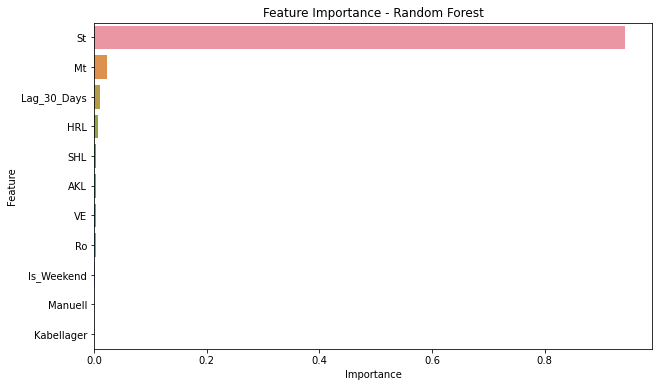

        Feature  Importance
0            St    0.943421
1            Mt    0.023030
5   Lag_30_Days    0.009974
7           HRL    0.006797
10          SHL    0.003738
6           AKL    0.003653
3            VE    0.003559
2            Ro    0.003209
4    Is_Weekend    0.002596
9       Manuell    0.000016
8    Kabellager    0.000006


In [59]:
# Fit the model
rf_model = models['Random Forest']
rf_model.fit(X_train_arr, y_train_arr)

rf_importances = rf_model.feature_importances_

features = numerical_columns + list(no_of_picks_and_pick_volume_per_date['Warehouse_Section'].unique())
rf_feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_importances
})

# Sort by absolute value of the coefficients to get most important features
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances (coefficients)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print(rf_feature_importance_df)

Here we can see that Random Forest was relying solely on St for making its predictions. This doesn't make it ideal in a real-world scenario where the No_of_Picks could depend on multiple factors. Hence we can conclude that this model isn't great for future predictions

`LightGBM` Feature Importance

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 10153, number of used features: 11
[LightGBM] [Info] Start training from score 2559.347779


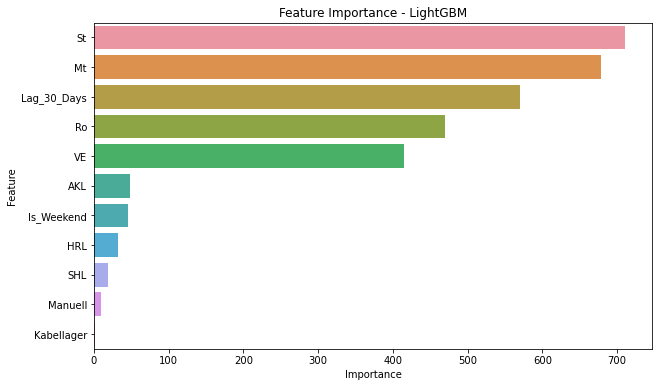

        Feature  Importance
0            St         711
1            Mt         678
5   Lag_30_Days         570
2            Ro         470
3            VE         415
6           AKL          48
4    Is_Weekend          46
7           HRL          32
10          SHL          19
9       Manuell          10
8    Kabellager           1


In [61]:
# Fit the model
lgb_model = models['LightGBM']
lgb_model.fit(X_train_arr, y_train_arr)

# Extract feature importances
lgb_importances = lgb_model.feature_importances_

# Combine the feature names with their importance values
lgb_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': lgb_importances
})

# Sort by importance in descending order
lgb_feature_importance = lgb_feature_importance.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgb_feature_importance)
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the sorted feature importance
print(lgb_feature_importance[['Feature', 'Importance']])

LightGBM is providing more balanced feature importance compared to Random Forest, where St was overwhelmingly important (94%). The importance of St in LightGBM (711) is still significant, but other features like Mt, Lag_30_Days, and Ro also have notable contributions. This suggests that LightGBM is more flexible in considering various features

`XGBoost` Feature Importance

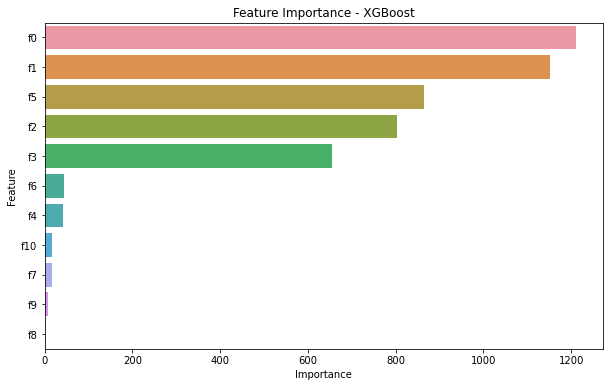

   Feature  Importance
0       f0      1211.0
1       f1      1152.0
5       f5       864.0
2       f2       802.0
3       f3       655.0
6       f6        44.0
4       f4        43.0
10     f10        18.0
7       f7        16.0
9       f9         8.0
8       f8         2.0


In [62]:
# Fit the model
xgb_model = models['XGBoost']
xgb_model.fit(X_train_arr, y_train_arr)

# Extract feature importances (booster-based method)
xgb_importances = xgb_model.get_booster().get_score(importance_type='weight')

# Convert to a DataFrame for better readability
xgb_feature_importance = pd.DataFrame({
    'Feature': list(xgb_importances.keys()),
    'Importance': list(xgb_importances.values())
})

# Sort by importance in descending order
xgb_feature_importance = xgb_feature_importance.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the sorted feature importance
print(xgb_feature_importance[['Feature', 'Importance']])

Conclusion

Random Forest was relying solely on St for making its predictions. This doesn't make it ideal. The feature importance of XGBoost is spread out similar to LightGBM and should definitely be better at making predicitions than Random Forest on unseen data. 

Since LightGBM has a slighly higher R² (0.978591), lower RMSE (688.748014) and faster execution time (0.064014 s) than XGBoost, we can conclude that `LightGBM` is the best model for making predictions on the `No_of_Picks`

The insights gained from feature importance would help the business understand which factors most affect the number of picks per day, allowing for better staff allocation.